In [ ]:
!pip install scikit-uplift

In [ ]:
!pip install catboost

In [76]:
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_hillstrom
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation
from sklift.models import TwoModels

In [9]:
df = fetch_hillstrom()
data, target, treatment = df.data, df.target, df.treatment

Hillstrom dataset:   0%|          | 0.00/443k [00:00<?, ?iB/s]

In [10]:
data.shape, target.shape, treatment.shape

((64000, 8), (64000,), (64000,))

In [18]:
data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web


In [16]:
treatment.head()

0    Womens E-Mail
1        No E-Mail
2    Womens E-Mail
3      Mens E-Mail
4    Womens E-Mail
Name: segment, dtype: object

In [17]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: visit, dtype: int64

In [14]:
df_train = pd.concat([data, treatment, target], axis=1)
df_train

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0
...,...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail,0
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail,0
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail,0
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail,0


In [46]:
df_train.segment = df_train.segment.map({'Womens E-Mail':1,'Mens E-Mail':1, 'No E-Mail':0  })

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57397 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          57397 non-null  int64  
 1   history_segment  57397 non-null  object 
 2   history          57397 non-null  float64
 3   mens             57397 non-null  int64  
 4   womens           57397 non-null  int64  
 5   zip_code         57397 non-null  object 
 6   newbie           57397 non-null  int64  
 7   channel          57397 non-null  object 
 8   segment          57397 non-null  object 
 9   visit            57397 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 4.8+ MB


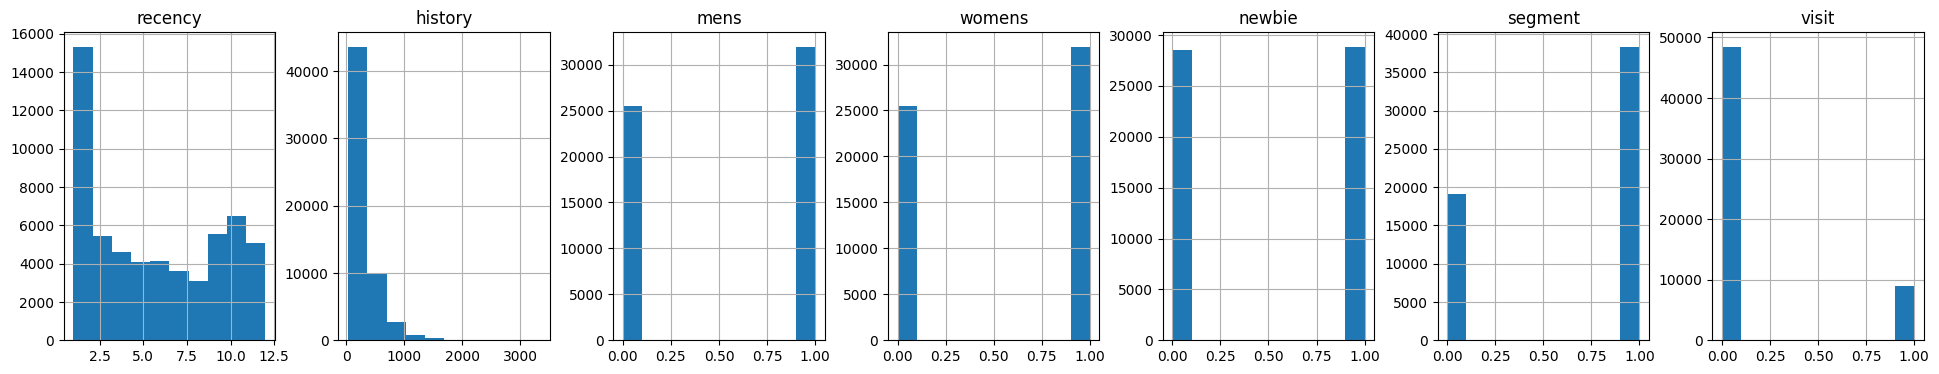

In [48]:
df_train.hist(figsize=(24,4), layout=(-1, 7))
plt.show()

In [49]:
df_train.isna().sum()

recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
segment            0
visit              0
dtype: int64

In [50]:
df_train.drop_duplicates(inplace=True)

In [51]:
df_train.shape

(56967, 10)

In [52]:
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=42)

In [68]:
X_train = df_train.drop(columns=['visit', 'segment']).loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'visit']
treat_train = df_train.loc[indices_learn, 'segment']

X_val = df_train.drop(columns=['visit', 'segment']).loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'visit']
treat_val =  df_train.loc[indices_valid, 'segment']
categorical = df_train.select_dtypes(include=['object'])

In [77]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

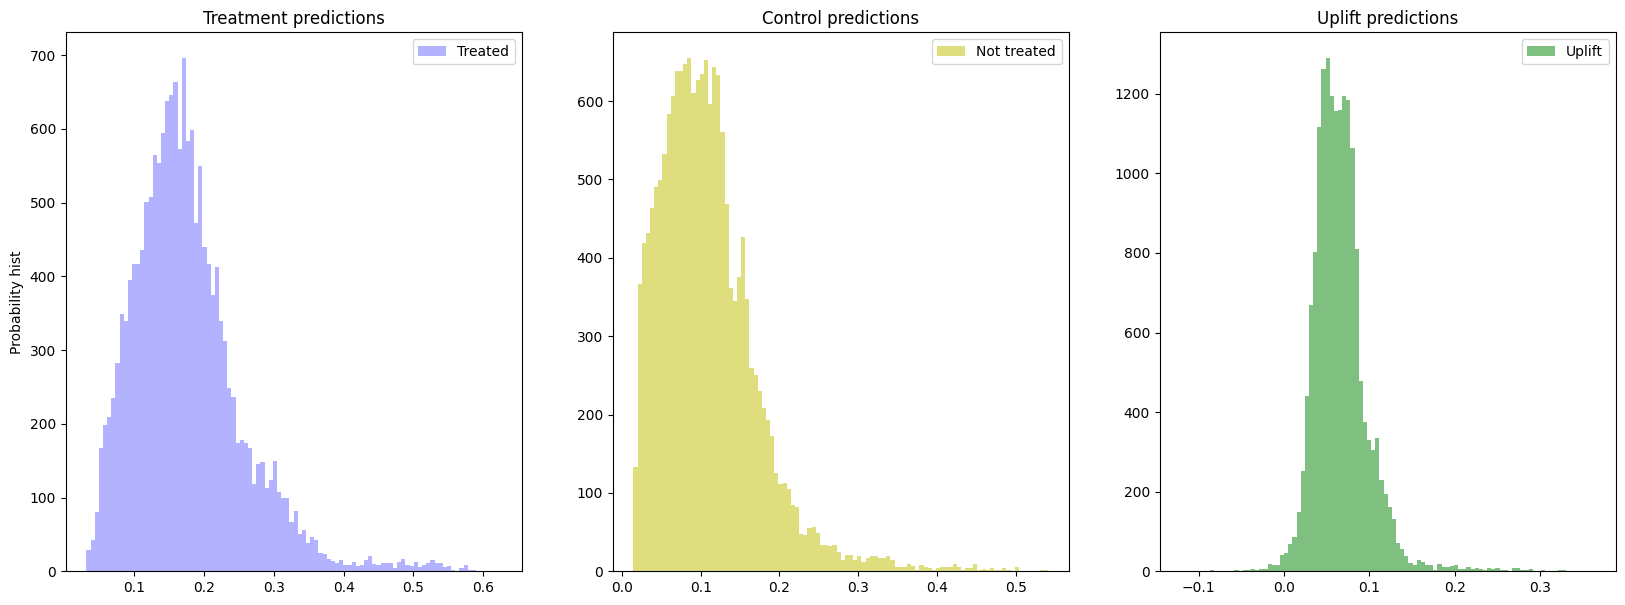

In [78]:
sm = SoloModel(CatBoostClassifier(thread_count=-1, random_state=42, verbose=False))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': list(categorical.columns)})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [71]:
sm_featimp = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_featimp

,feature_name,feature_score
0,history,26.648194
1,recency,15.065802
2,zip_code,12.492410
3,treatment,10.008639
4,newbie,9.649482
5,channel,7.743247
6,history_segment,7.133729
7,womens,6.328269
8,mens,4.930228


In [79]:
ct = ClassTransformation(CatBoostClassifier(thread_count=-1, random_state=42, verbose=False))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': list(categorical.columns)})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

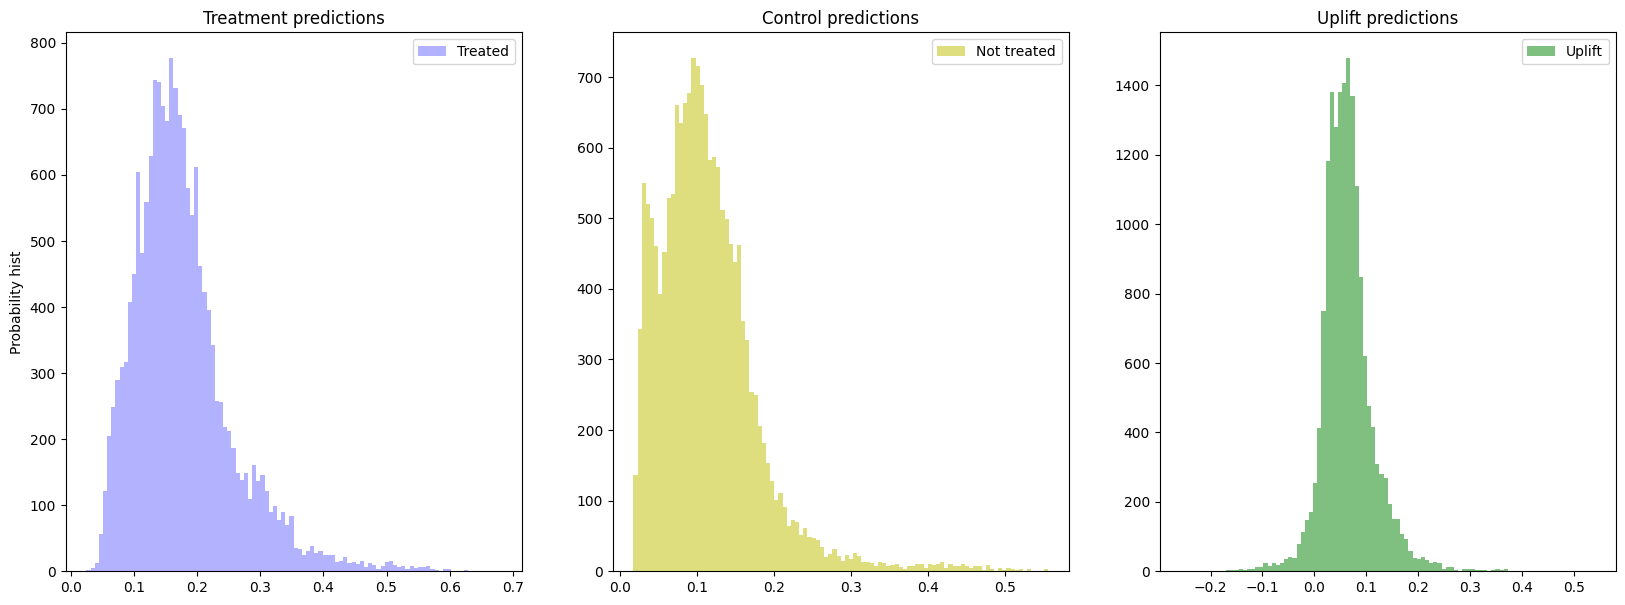

In [82]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(thread_count=-1, random_state=42, verbose=False),
    estimator_ctrl=CatBoostClassifier(thread_count=-1, random_state=42, verbose=False),
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': list(categorical.columns)},
    estimator_ctrl_fit_params={'cat_features': list(categorical.columns)}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

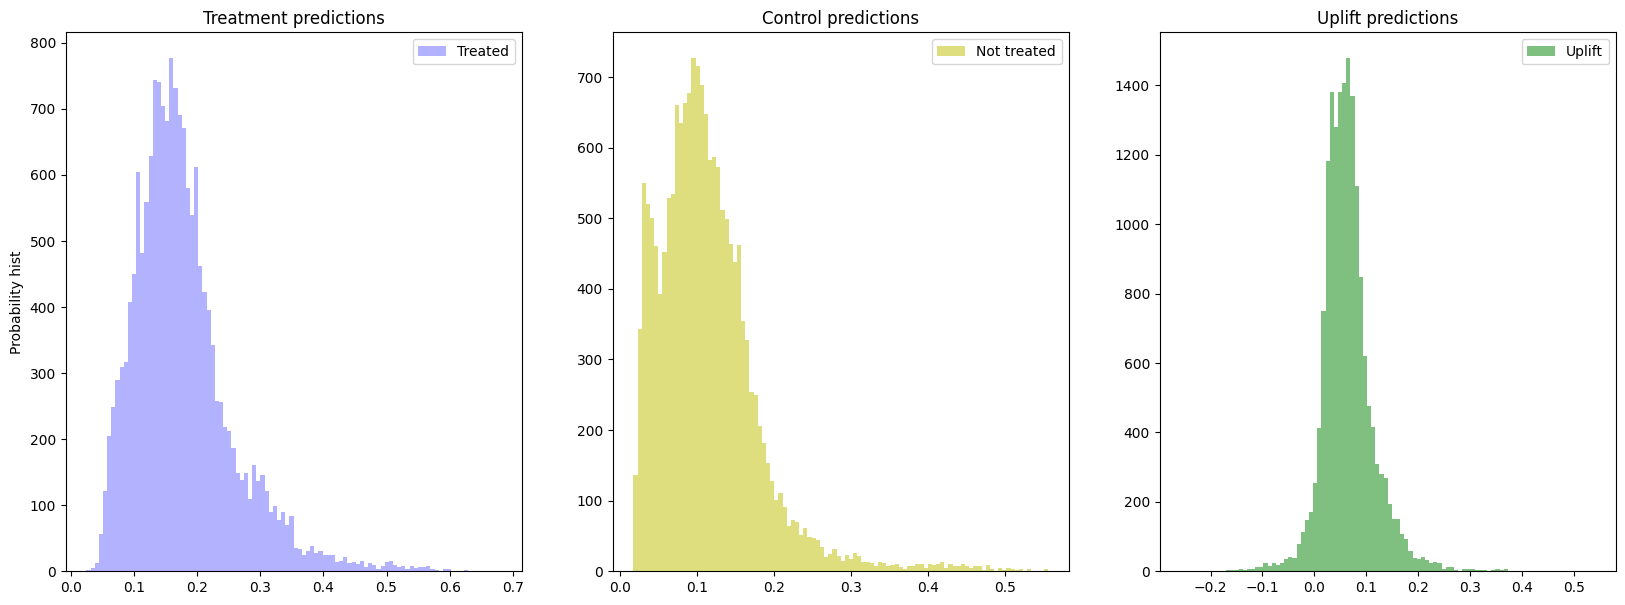

In [83]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(thread_count=-1, random_state=42, verbose=False),
    estimator_ctrl=CatBoostClassifier(thread_count=-1, random_state=42, verbose=False),
    method='ddr_control'
)
tm_ctrl = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': list(categorical.columns)},
    estimator_ctrl_fit_params={'cat_features': list(categorical.columns)}
)

uplift_tm = tm_ctrl.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_)

array([<Axes: title={'center': 'Treatment predictions'}, ylabel='Probability hist'>,
       <Axes: title={'center': 'Control predictions'}>,
       <Axes: title={'center': 'Uplift predictions'}>], dtype=object)

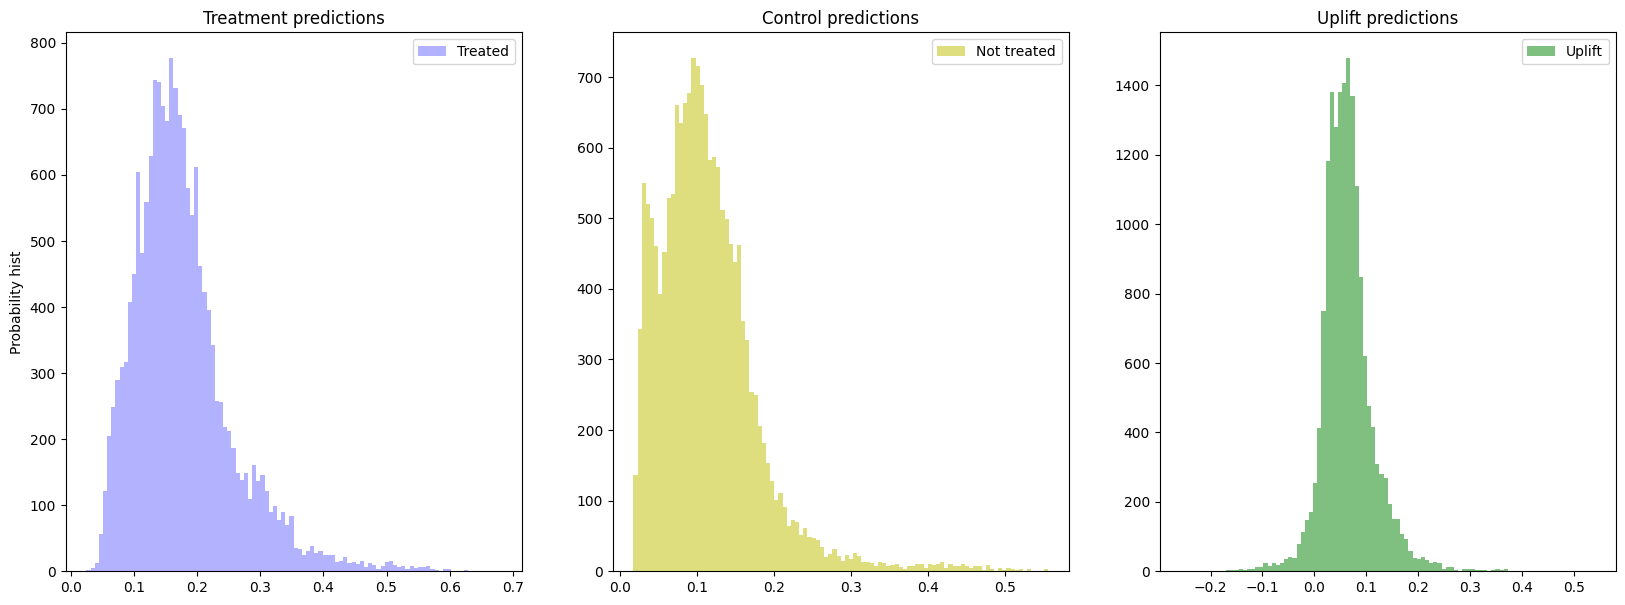

In [84]:
tm_trmnt = TwoModels(
    estimator_trmnt=CatBoostClassifier(thread_count=-1, random_state=42, verbose=False),
    estimator_ctrl=CatBoostClassifier(thread_count=-1, random_state=42, verbose=False),
    method='ddr_treatment'
)
tm_trmnt = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': list(categorical.columns)},
    estimator_ctrl_fit_params={'cat_features': list(categorical.columns)}
)

uplift_tm = tm_trmnt.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels_ddr_treatment')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm_trmnt.trmnt_preds_, ctrl_preds=tm_trmnt.ctrl_preds_)

In [85]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.075893
2,TwoModels,0.067974
3,TwoModels_ddr_control,0.067974
4,TwoModels_ddr_treatment,0.067974
1,ClassTransformation,0.060002
